# Задание 1.1 - Метод К-ближайших соседей (K-neariest neighbor classifier)

В первом задании вы реализуете один из простейших алгоритмов машинного обучения - классификатор на основе метода K-ближайших соседей.
Мы применим его к задачам
- бинарной классификации (то есть, только двум классам)
- многоклассовой классификации (то есть, нескольким классам)

Так как методу необходим гиперпараметр (hyperparameter) - количество соседей, мы выберем его на основе кросс-валидации (cross-validation).

Наша основная задача - научиться пользоваться numpy и представлять вычисления в векторном виде, а также ознакомиться с основными метриками, важными для задачи классификации.

Перед выполнением задания:
- запустите файл `download_data.sh`, чтобы скачать данные, которые мы будем использовать для тренировки
- установите все необходимые библиотеки, запустив `pip install -r requirements.txt` (если раньше не работали с `pip`, вам сюда - https://pip.pypa.io/en/stable/quickstart/)

Если вы раньше не работали с numpy, вам может помочь tutorial. Например этот:  
http://cs231n.github.io/python-numpy-tutorial/

In [135]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [136]:
from dataset import load_svhn
from knn import KNN
from metrics import binary_classification_metrics, multiclass_accuracy

# Загрузим и визуализируем данные

В задании уже дана функция `load_svhn`, загружающая данные с диска. Она возвращает данные для тренировки и для тестирования как numpy arrays.

Мы будем использовать цифры из датасета Street View House Numbers (SVHN, http://ufldl.stanford.edu/housenumbers/), чтобы решать задачу хоть сколько-нибудь сложнее MNIST.

In [137]:
train_X, train_y, test_X, test_y = load_svhn("data", max_train=1000, max_test=100)

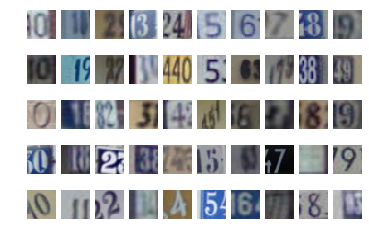

In [138]:
samples_per_class = 5  # Number of samples per class to visualize
plot_index = 1
for example_index in range(samples_per_class):
    for class_index in range(10):
        plt.subplot(5, 10, plot_index)
        image = train_X[train_y == class_index][example_index]
        plt.imshow(image.astype(np.uint8))
        plt.axis('off')
        plot_index += 1

# Сначала реализуем KNN для бинарной классификации

В качестве задачи бинарной классификации мы натренируем модель, которая будет отличать цифру 0 от цифры 9.

In [139]:
# First, let's prepare the labels and the source data

# Only select 0s and 9s
binary_train_mask = (train_y == 0) | (train_y == 9)
binary_train_X = train_X[binary_train_mask]
binary_train_y = train_y[binary_train_mask] == 0

binary_test_mask = (test_y == 0) | (test_y == 9)
binary_test_X = test_X[binary_test_mask]
binary_test_y = test_y[binary_test_mask] == 0

# Reshape to 1-dimensional array [num_samples, 32*32*3]
binary_train_X = binary_train_X.reshape(binary_train_X.shape[0], -1)
binary_test_X = binary_test_X.reshape(binary_test_X.shape[0], -1)

In [140]:
# Create the classifier and call fit to train the model
# KNN just remembers all the data
knn_classifier = KNN(k=1)
knn_classifier.fit(binary_train_X, binary_train_y)

## Пришло время написать код! 

Последовательно реализуйте функции `compute_distances_two_loops`, `compute_distances_one_loop` и `compute_distances_no_loops`
в файле `knn.py`.

Эти функции строят массив расстояний между всеми векторами в тестовом наборе и в тренировочном наборе.  
В результате они должны построить массив размера `(num_test, num_train)`, где координата `[i][j]` соотвествует расстоянию между i-м вектором в test (`test[i]`) и j-м вектором в train (`train[j]`).

**Обратите внимание** Для простоты реализации мы будем использовать в качестве расстояния меру L1 (ее еще называют [Manhattan distance](https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D1%81%D1%81%D1%82%D0%BE%D1%8F%D0%BD%D0%B8%D0%B5_%D0%B3%D0%BE%D1%80%D0%BE%D0%B4%D1%81%D0%BA%D0%B8%D1%85_%D0%BA%D0%B2%D0%B0%D1%80%D1%82%D0%B0%D0%BB%D0%BE%D0%B2)).

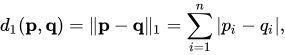

In [141]:
# TODO: implement compute_distances_two_loops in knn.py
dists = knn_classifier.compute_distances_two_loops(binary_test_X)
assert np.isclose(dists[0, 10], np.sum(np.abs(binary_test_X[0] - binary_train_X[10])))

In [142]:
knn_classifier.train_X.shape

(121, 3072)

In [143]:
binary_test_y.shape

(16,)

In [144]:
# TODO: implement compute_distances_one_loop in knn.py
dists = knn_classifier.compute_distances_one_loop(binary_test_X)
assert np.isclose(dists[8, 10], np.sum(np.abs(binary_test_X[8] - binary_train_X[10])))


In [145]:
# TODO: implement compute_distances_no_loops in knn.py
dists = knn_classifier.compute_distances_no_loops(binary_test_X)
assert np.isclose(dists[0, 10], np.sum(np.abs(binary_test_X[0] - binary_train_X[10])))


In [146]:
# Lets look at the performance difference
%timeit knn_classifier.compute_distances_two_loops(binary_test_X)
%timeit knn_classifier.compute_distances_one_loop(binary_test_X)
%timeit knn_classifier.compute_distances_no_loops(binary_test_X)

23.7 ms ± 689 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
7.74 ms ± 1.09 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
9.76 ms ± 53.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [147]:
# TODO: implement predict_labels_binary in knn.py
prediction = knn_classifier.predict(binary_test_X)

In [148]:
# TODO: implement binary_classification_metrics in metrics.py
precision, recall, f1, accuracy = binary_classification_metrics(prediction, binary_test_y)
print("KNN with k = %s" % knn_classifier.k)
print("Accuracy: %4.2f, Precision: %4.2f, Recall: %4.2f, F1: %4.2f" % (accuracy, precision, recall, f1)) 

KNN with k = 1
Accuracy: 0.56, Precision: 0.73, Recall: 0.67, F1: 0.70


In [149]:
# Let's put everything together and run KNN with k=3 and see how we do
knn_classifier_3 = KNN(k = 1)
knn_classifier_3.fit(binary_train_X, binary_train_y)
prediction = knn_classifier_3.predict(binary_test_X)

precision, recall, f1, accuracy = binary_classification_metrics(prediction, binary_test_y)
print("KNN with k = %s" % knn_classifier_3.k)
print("Accuracy: %4.2f, Precision: %4.2f, Recall: %4.2f, F1: %4.2f" % (accuracy, precision, recall, f1)) 

KNN with k = 1
Accuracy: 0.56, Precision: 0.73, Recall: 0.67, F1: 0.70


In [150]:
binary_test_X.shape

(16, 3072)

# Кросс-валидация (cross-validation)

Попробуем найти лучшее значение параметра k для алгоритма KNN! 

Для этого мы воспользуемся k-fold cross-validation (https://en.wikipedia.org/wiki/Cross-validation_(statistics)#k-fold_cross-validation). Мы разделим тренировочные данные на 5 фолдов (folds), и по очереди будем использовать каждый из них в качестве проверочных данных (validation data), а остальные -- в качестве тренировочных (training data).

В качестве финальной оценки эффективности k мы усредним значения F1 score на всех фолдах.
После этого мы просто выберем значение k с лучшим значением метрики.

*Бонус*: есть ли другие варианты агрегировать F1 score по всем фолдам? Напишите плюсы и минусы в клетке ниже.

In [151]:
x = 5
print(binary_train_X.shape[0]/x)
print(int(binary_train_X.shape[0]/x))

24.2
24


In [152]:
binary_train_X.shape

(121, 3072)

In [153]:
train_folds_X[0].shape

(200, 3072)

In [154]:
k = 2
train_folds_set =set(range(num_folds)) - {k}
np.concatenate([train_folds_X[i] for i in train_folds_list]).shape

(800, 3072)

In [155]:
[train_folds_X[i] for i in {2,4}]

[array([[211., 202., 198., ...,  74.,  72., 100.],
        [ 81.,  87., 106., ...,  67.,  66.,  79.],
        [112., 106.,  97., ..., 111., 106., 100.],
        ...,
        [107., 101., 101., ..., 107., 109., 104.],
        [141., 133., 130., ...,  83.,  84., 114.],
        [ 54.,  43.,  43., ...,  68.,  44.,  36.]], dtype=float32),
 array([[ 55.,  28.,  33., ...,  87.,  39.,  35.],
        [ 91., 103., 120., ..., 127., 122., 123.],
        [165., 165., 163., ..., 121., 129., 148.],
        ...,
        [224., 228., 240., ..., 185., 195., 207.],
        [142., 178., 214., ..., 132., 150., 170.],
        [ 22.,  35.,  41., ...,  18.,  43.,  50.]], dtype=float32)]

In [156]:
# Find the best k using cross-validation based on F1 score
num_folds = 5

fold_size = int(binary_train_X.shape[0] / num_folds)
binary_train_X_cv = binary_train_X[:fold_size * num_folds] 
binary_train_y_cv = binary_train_y[:fold_size * num_folds] 
train_folds_X = np.split(binary_train_X_cv,num_folds)
train_folds_y = np.split(binary_train_y_cv,num_folds)

# TODO: split the training data in 5 folds and store them in train_folds_X/train_folds_y

k_choices = [1, 2, 3, 5, 8, 10, 15, 20, 25, 50]
#k_choices = [1,2,3,5]
k_to_f1 = {}  # dict mapping k values to mean F1 scores (int -> float)

for k in k_choices:
    #print("KNN with k = %s" % k)
    # TODO: perform cross-validation
    # Go through every fold and use it for testing and all other folds for training
    # Perform training and produce F1 score metric on the validation dataset
    # Average F1 from all the folds and write it into k_to_f1
    f1 = 0
    for test_fold_index in range(num_folds):
        train_folds_set = set(range(num_folds)) - {test_fold_index}
        current_train_X = np.concatenate([train_folds_X[i] for i in train_folds_set])
        current_train_y = np.concatenate([train_folds_y[i] for i in train_folds_set])
        
        current_test_X = train_folds_X[test_fold_index]
        current_test_y = train_folds_y[test_fold_index]
        knn_classifier = KNN(k)
        knn_classifier.fit(current_train_X, current_train_y)
        prediction = knn_classifier.predict(current_test_X)
        precision, recall, f1_current, accuracy = binary_classification_metrics(prediction, current_test_y)  
        f1 +=f1_current
        #print("test_fold_index: %i, Accuracy: %4.2f, Precision: %4.2f, Recall: %4.2f, F1: %4.2f" % (test_fold_index,accuracy, precision, recall, f1_current)) 
    f1 /= num_folds
   # print("Averaged f1: %4.2f" % (f1))
    k_to_f1[k] = f1
    pass

for k in sorted(k_to_f1):
    print('k = %d, f1 = %f' % (k, k_to_f1[k]))
    


k = 1, f1 = 0.673180
k = 2, f1 = 0.689687
k = 3, f1 = 0.683108
k = 5, f1 = 0.600626
k = 8, f1 = 0.645972
k = 10, f1 = 0.633999
k = 15, f1 = 0.632905
k = 20, f1 = 0.660728
k = 25, f1 = 0.647727
k = 50, f1 = 0.653888


### Проверим, как хорошо работает лучшее значение k на тестовых данных (test data)

In [163]:
# TODO Set the best k to the best value found by cross-validation
best_k = max(k_to_f1, key = lambda x: k_to_f1.get(x))

best_knn_classifier = KNN(k=best_k)
best_knn_classifier.fit(binary_train_X, binary_train_y)
prediction = best_knn_classifier.predict(binary_test_X)

precision, recall, f1, accuracy = binary_classification_metrics(prediction, binary_test_y)
print("Best KNN with k = %s" % best_k)
print("Accuracy: %4.2f, Precision: %4.2f, Recall: %4.2f, F1: %4.2f" % (accuracy, precision, recall, f1)) 

Best KNN with k = 2
Accuracy: 0.56, Precision: 0.69, Recall: 0.75, F1: 0.72


# Многоклассовая классификация (multi-class classification)

Переходим к следующему этапу - классификации на каждую цифру.

In [165]:
# Now let's use all 10 classes
train_X = train_X.reshape(train_X.shape[0], -1)
test_X = test_X.reshape(test_X.shape[0], -1)

knn_classifier = KNN(k=4)
knn_classifier.fit(train_X, train_y)

In [166]:
# TODO: Implement predict_labels_multiclass
predict = knn_classifier.predict(test_X)

In [167]:
# TODO: Implement multiclass_accuracy
accuracy = multiclass_accuracy(predict, test_y)
print("Accuracy: %4.2f" % accuracy)

Accuracy: 0.27


Снова кросс-валидация. Теперь нашей основной метрикой стала точность (accuracy), и ее мы тоже будем усреднять по всем фолдам.

In [171]:
# Find the best k using cross-validation based on accuracy
num_folds = 5

fold_size = int(train_X.shape[0] / num_folds)
train_X_cv = train_X[ : fold_size * num_folds] 
train_y_cv = train_y[ : fold_size * num_folds] 
train_folds_X = np.split(train_X_cv, num_folds)
train_folds_y = np.split(train_y_cv, num_folds)
 
# TODO: split the training data in 5 folds and store them in train_folds_X/train_folds_y

#k_choices = [1, 2, 3, 5, 8, 10, 15, 20, 25, 50]
k_choices = [2, 3, 5, 8, 10, 15, 20, 25, 50]
k_to_accuracy = {}

for k in k_choices:
    print("KNN with k = %s" % k)
    accuracy = 0
    for test_fold_index in range(num_folds):
        train_folds_set = set(range(num_folds)) - {test_fold_index}
        current_train_X = np.concatenate([train_folds_X[i] for i in train_folds_set])
        current_train_y = np.concatenate([train_folds_y[i] for i in train_folds_set])
        
        current_test_X = train_folds_X[test_fold_index]
        current_test_y = train_folds_y[test_fold_index]
        knn_classifier = KNN(k)
        knn_classifier.fit(current_train_X, current_train_y)
        prediction = knn_classifier.predict(current_test_X)
        accuracy_current = multiclass_accuracy(prediction, current_test_y)
        accuracy += accuracy_current
        #print("Accuracy: %4.2f" % accuracy_current) 
    accuracy /= num_folds
   # print("Averaged f1: %4.2f" % (f1))
    k_to_accuracy[k] = accuracy
    pass

for k in sorted(k_to_accuracy):
    print('k = %d, accuracy = %4.2f' % (k, k_to_accuracy[k]))

KNN with k = 2
KNN with k = 3
KNN with k = 5
KNN with k = 8
KNN with k = 10
KNN with k = 15
KNN with k = 20
KNN with k = 25
KNN with k = 50
k = 2, accuracy = 0.24
k = 3, accuracy = 0.24
k = 5, accuracy = 0.25
k = 8, accuracy = 0.24
k = 10, accuracy = 0.23
k = 15, accuracy = 0.23
k = 20, accuracy = 0.24
k = 25, accuracy = 0.24
k = 50, accuracy = 0.22


### Финальный тест - классификация на 10 классов на тестовой выборке (test data)

Если все реализовано правильно, вы должны увидеть точность не менее **0.2**.

In [172]:
# TODO Set the best k as a best from computed
best_k = max(k_to_accuracy, key = lambda x: k_to_accuracy.get(x))

best_knn_classifier = KNN(k = best_k)
best_knn_classifier.fit(train_X, train_y)
prediction = best_knn_classifier.predict(test_X)

# Accuracy should be around 20%!
accuracy = multiclass_accuracy(prediction, test_y)
print("Accuracy: %4.2f" % accuracy)

Accuracy: 0.25


In [ ]:
print(best_k)